<a href="https://colab.research.google.com/github/LahiWeer/2330902-ML_CW/blob/master/ML%20models/NN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Step 1: Load the dataset
data_url = 'https://raw.githubusercontent.com/LahiWeer/2330902-ML_CW/refs/heads/master/Preprocessing/resampled_and_original_data.csv'
data = pd.read_csv(data_url)

In [21]:
# Step 2: Separate features (X) and target (y)
X = data.drop('y', axis=1)
y = data['y']

# Step 3: List of columns to scale
columns_to_scale = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
                    'default', 'housing', 'loan', 'contact', 'month',
                    'day_of_week', 'poutcome', 'education']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Apply scaling only to specific columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only the specified columns
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# Step 6: Initialize model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = Adam(learning_rate=0.0025)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and reduce learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Step 7: Hyperparameter tuning with Stratified K-Fold Cross Validation
history = []  # List to store history of training for plotting

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kfold.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model and save the history
    fold_history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=700,
        batch_size=128,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Store the history of each fold
    history.append(fold_history.history)

Epoch 1/700


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7668 - loss: 0.4901 - val_accuracy: 0.8434 - val_loss: 0.3661 - learning_rate: 0.0025
Epoch 2/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8415 - loss: 0.3690 - val_accuracy: 0.8486 - val_loss: 0.3516 - learning_rate: 0.0025
Epoch 3/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8475 - loss: 0.3561 - val_accuracy: 0.8459 - val_loss: 0.3502 - learning_rate: 0.0025
Epoch 4/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8501 - loss: 0.3475 - val_accuracy: 0.8498 - val_loss: 0.3408 - learning_rate: 0.0025
Epoch 5/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8566 - loss: 0.3396 - val_accuracy: 0.8530 - val_loss: 0.3389 - learning_rate: 0.0025
Epoch 6/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8556 - loss: 0.3385 - val_accuracy: 0.8511 - val_loss: 0.3420 - learning_rate: 0.0025
Epoch 7/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8570 - loss: 0.3369 - val_

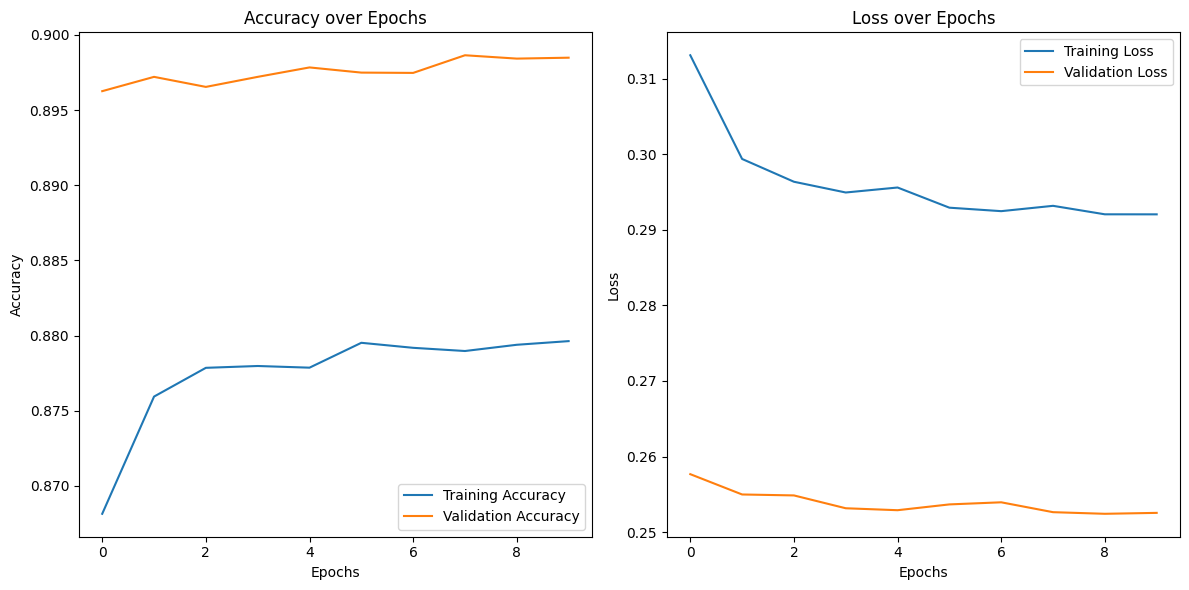

In [22]:
# Step 8: Plot Accuracy and Loss over Epochs
# Initialize lists to store the accuracy and loss for all folds
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Find the minimum number of epochs across all folds
min_epochs = min([len(fold_history['accuracy']) for fold_history in history])

# Collect history for each fold and trim to the minimum number of epochs
for fold_history in history:
    train_accuracies.append(fold_history['accuracy'][:min_epochs])
    val_accuracies.append(fold_history['val_accuracy'][:min_epochs])
    train_losses.append(fold_history['loss'][:min_epochs])
    val_losses.append(fold_history['val_loss'][:min_epochs])

# Convert lists to numpy arrays and calculate average across folds
avg_train_accuracy = np.mean(train_accuracies, axis=0)
avg_val_accuracy = np.mean(val_accuracies, axis=0)
avg_train_loss = np.mean(train_losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(avg_train_accuracy, label='Training Accuracy')
plt.plot(avg_val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Step 9: Predict on Test Data
y_pred_prob = model.predict(X_test_scaled)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int)    # Convert probabilities to binary predictions

# Step 10: Evaluate Model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.8870001618908856


In [24]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      6177
           1       0.90      0.88      0.89      6177

    accuracy                           0.89     12354
   macro avg       0.89      0.89      0.89     12354
weighted avg       0.89      0.89      0.89     12354

